In [278]:
# import required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


In [279]:
# read data
train = pd.read_csv("../data_set/train.csv")
test = pd.read_csv("../data_set/test.csv")
store = pd.read_csv("../data_set/store.csv")

In [280]:
#train
train.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [281]:
# check nan (train)
display(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [282]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [283]:
train['Date'] = pd.to_datetime(train['Date'], errors='coerce')

In [284]:
summary = pd.DataFrame({
    'Column': train.columns,
    'Unique Values': [train[col].nunique() for col in train.columns],
    'Min': [train[col].min() if np.issubdtype(train[col].dtype, np.number) or np.issubdtype(train[col].dtype, np.datetime64) else None for col in train.columns],
    'Max': [train[col].max() if np.issubdtype(train[col].dtype, np.number) or np.issubdtype(train[col].dtype, np.datetime64) else None for col in train.columns],
})

summary.set_index('Column')


,Unique Values,Min,Max
Column,,,
Store,1115,1,1115
DayOfWeek,7,1,7
Date,942,2013-01-01 00:00:00,2015-07-31 00:00:00
Sales,21734,0,41551
Customers,4086,0,7388
Open,2,0,1
Promo,2,0,1
StateHoliday,5,None,None
SchoolHoliday,2,0,1


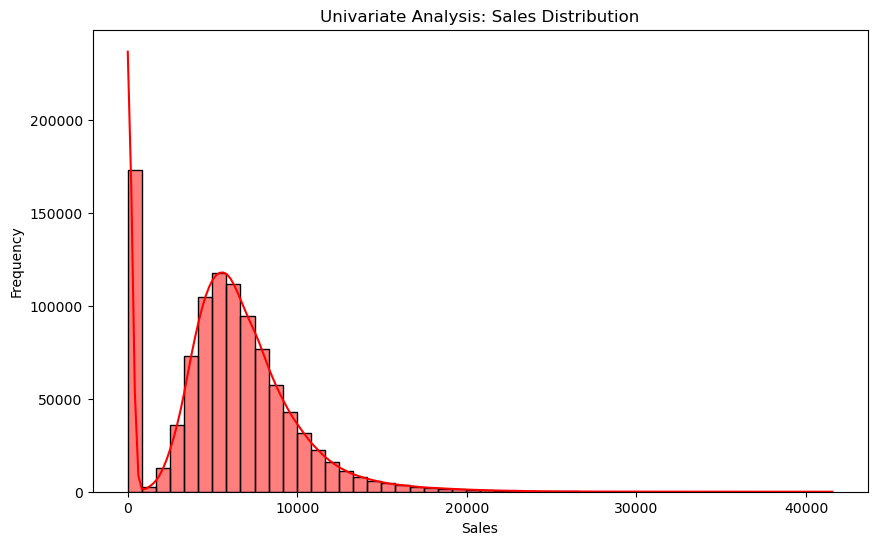

In [285]:
plt.figure(figsize=(10, 6))
sns.histplot(train['Sales'], kde=True, color='red', bins=50)
plt.title('Univariate Analysis: Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


In [286]:
train = train[train["Sales"] > 0]

## In the training data, we remove rows where sales are equal to zero:


### ✅ Why Remove Rows Where `Sales == 0`

- **Store Closed:**  
  Most instances with `Sales = 0` correspond to days when the store was closed. Including them may distort the model by teaching it to predict zeros where it shouldn't.

- **Focus on Business Days:**  
  Our goal is to predict sales on days when stores are open. Modeling closed-store behavior (zero sales) is not informative for actual forecasting.

- **Noise Reduction:**  
  Including many zero-sale days can introduce noise and skew the learning process, especially for models sensitive to outliers or class imbalance.

> ⚠️ **Note:** If our objective were to predict whether a store is open or closed, we would keep these rows. But since we're forecasting real sales amounts, it's best to remove them.


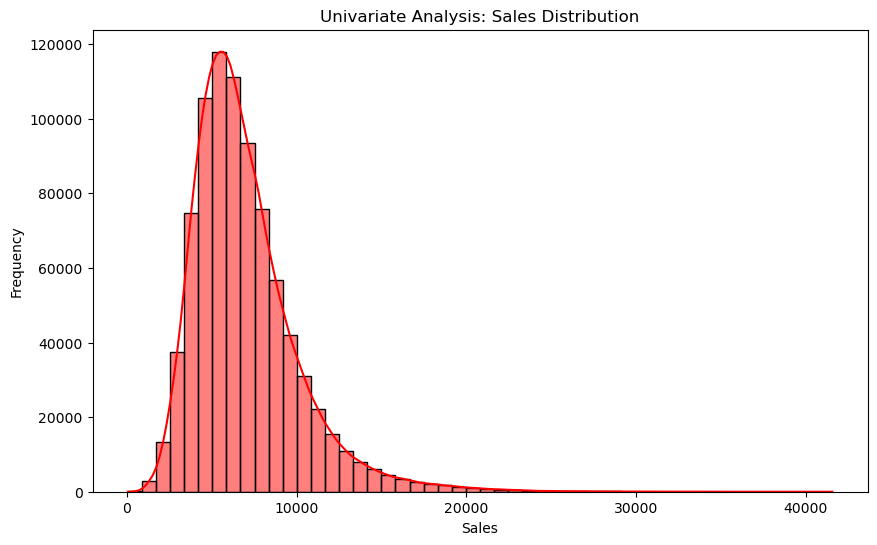

In [287]:

plt.figure(figsize=(10, 6))
sns.histplot(train['Sales'], kde=True, color='red', bins=50)
plt.title('Univariate Analysis: Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


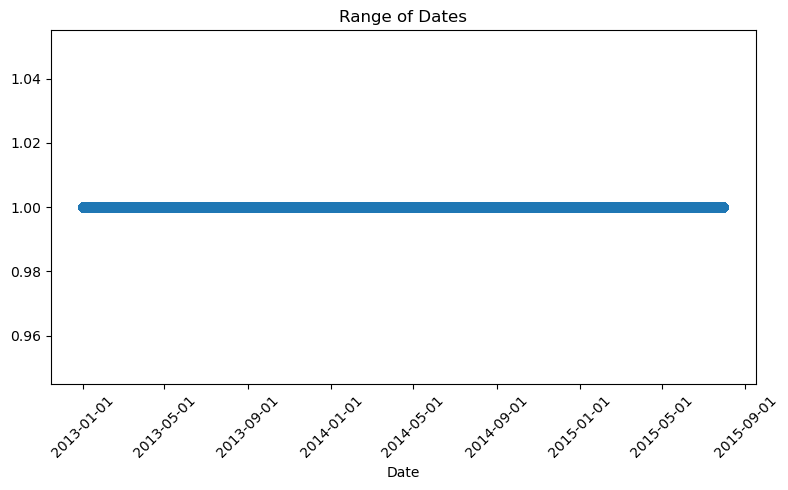

In [288]:
# Plotting the range of dates
plt.figure(figsize=(8, 5))
plt.plot(train['Date'], [1] * len(train['Date']), marker='o', linestyle='')

# Formatting the x-axis to show dates in yyyy-mm-dd format
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding title and labels
plt.title('Range of Dates')
plt.xlabel('Date')
plt.ylabel('')

# Show the plot
plt.tight_layout()
plt.show()

In [289]:
train.sort_values(by = 'Date', ascending=False, inplace=True)

# Print the maximum and minimum dates
max_date = train['Date'].max()
min_date = train['Date'].min()

print("\nMinimum Date:", min_date)
print("Maximum Date:", max_date)


Minimum Date: 2013-01-01 00:00:00
Maximum Date: 2015-07-31 00:00:00


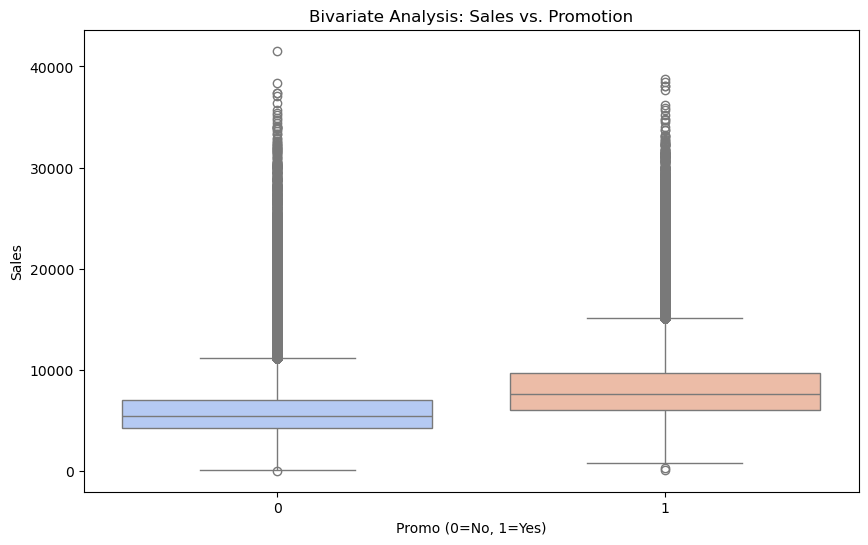

In [290]:
# Bivariate Analysis: Sales vs. Promotion
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data = train, palette='coolwarm')
plt.title('Bivariate Analysis: Sales vs. Promotion')
plt.xlabel('Promo (0=No, 1=Yes)')
plt.ylabel('Sales')
plt.show()

<Axes: xlabel='StateHoliday', ylabel='Sales'>

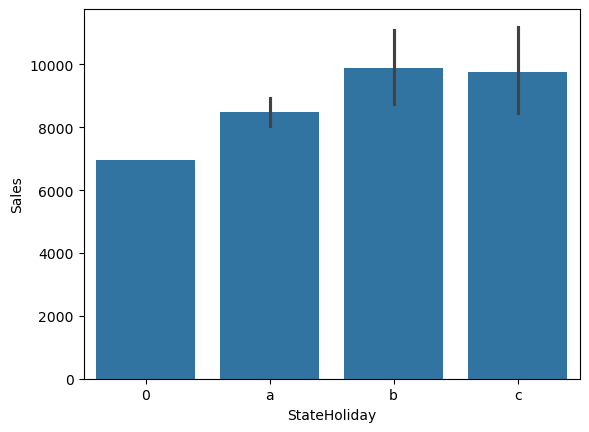

In [291]:
sns.barplot(data = train, x = 'StateHoliday', y = 'Sales')

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

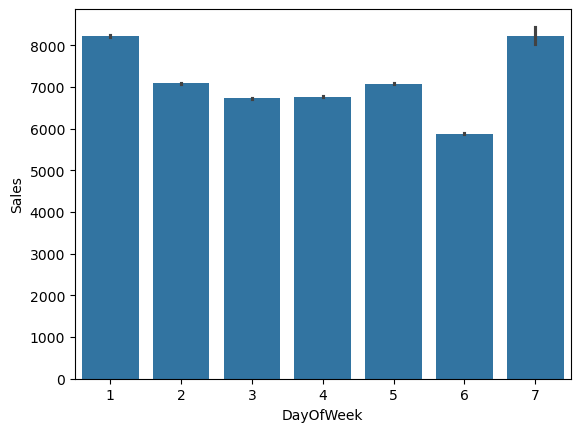

In [292]:
sns.barplot(x = train.DayOfWeek, y = train.Sales)

Text(0.5, 1.0, 'Sales vs Customers')

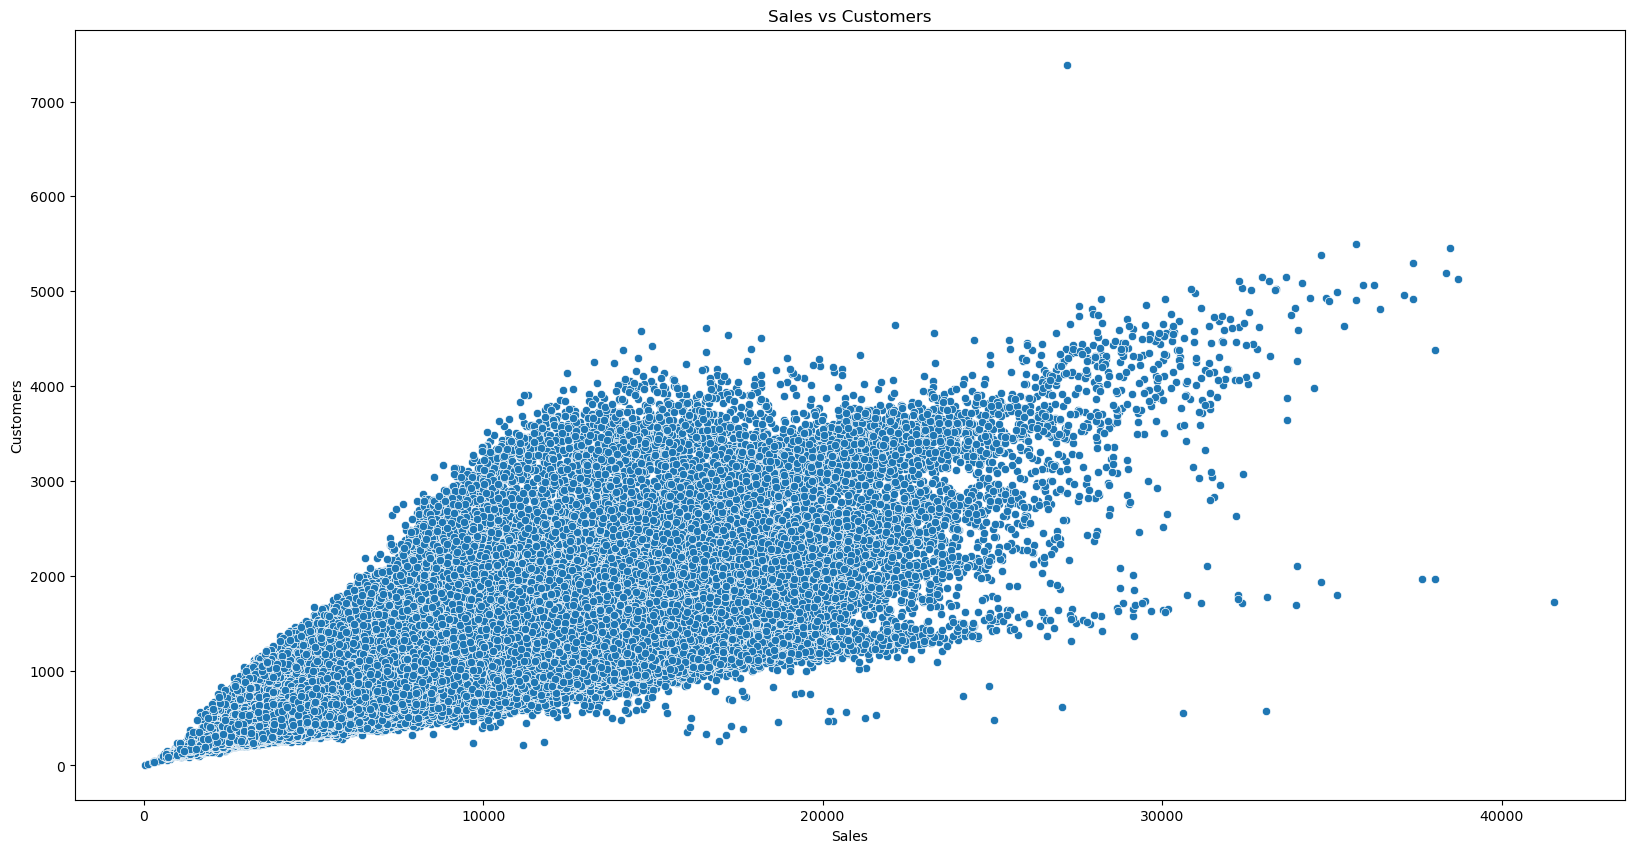

In [293]:
plt.figure(figsize=(20, 10))
# Sales vs Customers Scatter Plot
sns.scatterplot(x = train.Sales, y = train.Customers)
plt.title("Sales vs Customers")

In [294]:
#test
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [295]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [296]:
# check nan (test)
display(test.isnull().sum())

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

### As the store is expected to be open in the test dataset, we replace missing values in the `Open` column with `1`.


In [297]:
test.fillna(1, inplace = True)

In [298]:
# check nan (test)
display(test.isnull().sum())

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [299]:
test['Date'] = pd.to_datetime(test['Date'])
test['DayOfWeek'] = test['Date'].dt.dayofweek
test['Month'] = test['Date'].dt.month

In [300]:
summary = pd.DataFrame({
    'Column': test.columns,
    'Unique Values': [test[col].nunique() for col in test.columns],
    'Min': [test[col].min() if np.issubdtype(test[col].dtype, np.number) or np.issubdtype(test[col].dtype, np.datetime64) else None for col in test.columns],
    'Max': [test[col].max() if np.issubdtype(test[col].dtype, np.number) or np.issubdtype(test[col].dtype, np.datetime64) else None for col in test.columns],
})

summary.set_index('Column')


,Unique Values,Min,Max
Column,,,
Id,41088,1,41088
Store,856,1,1115
DayOfWeek,7,0,6
Date,48,2015-08-01 00:00:00,2015-09-17 00:00:00
Open,2,0.0,1.0
Promo,2,0,1
StateHoliday,2,None,None
SchoolHoliday,2,0,1
Month,2,8,9


In [301]:
#store
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [302]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [303]:
# check nan (store)
display(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [304]:
store.fillna(0, inplace = True)

In [305]:
# check nan (store)
display(store.isnull().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [306]:
summary = pd.DataFrame({
    'Column': store.columns,
    'Unique Values': [store[col].nunique() for col in store.columns],
    'Min': [store[col].min() if np.issubdtype(store[col].dtype, np.number) or np.issubdtype(store[col].dtype, np.datetime64) else None for col in store.columns],
    'Max': [store[col].max() if np.issubdtype(store[col].dtype, np.number) or np.issubdtype(store[col].dtype, np.datetime64) else None for col in store.columns],
})

summary.set_index('Column')


,Unique Values,Min,Max
Column,,,
Store,1115,1.0,1115.0
StoreType,4,NaN,NaN
Assortment,3,NaN,NaN
CompetitionDistance,655,0.0,75860.0
CompetitionOpenSinceMonth,13,0.0,12.0
CompetitionOpenSinceYear,24,0.0,2015.0
Promo2,2,0.0,1.0
Promo2SinceWeek,25,0.0,50.0
Promo2SinceYear,8,0.0,2015.0


In [307]:
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

In [308]:
train.StateHoliday.value_counts()

StateHoliday
0    731308
0    112120
a       694
b       145
c        71
Name: count, dtype: int64

In [309]:
# Replacing string '0' as integer '0'

train['StateHoliday'] = train['StateHoliday'].replace({'0': 0})
test['StateHoliday'] = test['StateHoliday'].replace({'0': 0})

train.StateHoliday.value_counts()

StateHoliday
0    843428
a       694
b       145
c        71
Name: count, dtype: int64

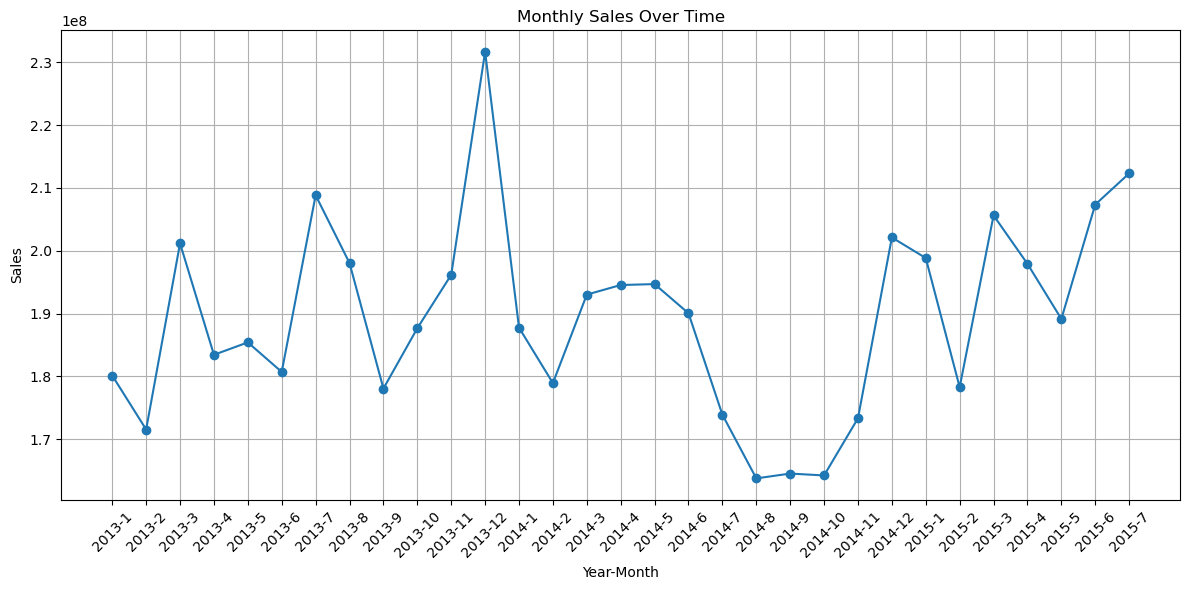

In [310]:
# Visualizing sales for each month over time

# Convert 'Date' column to datetime format
tmp_train = train.copy()
tmp_train['Date'] = pd.to_datetime(tmp_train['Date'])

# Extracting year and month from the 'Date' column
tmp_train['Year'] = tmp_train['Date'].dt.year
tmp_train['Month'] = tmp_train['Date'].dt.month
tmp_train['Day'] = tmp_train['Date'].dt.day

# Grouping by year and month, and summing up the sales for each group
monthly_sales = tmp_train.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Plotting the monthly sales trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str), monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

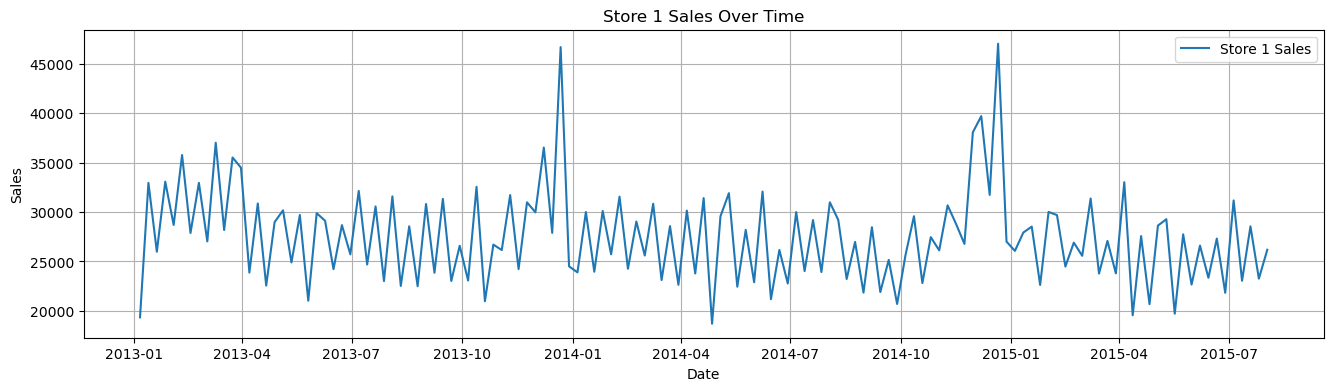

In [311]:
# Convert 'Date' to datetime if it's not already
train['Date'] = pd.to_datetime(train['Date'])

# Filter for store 1 and positive sales
store1_data = train[(train['Store'] == 1)]

# Set 'Date' as index for better time series plotting
store1_data.set_index('Date', inplace=True)

# Resample to weekly frequency for smoother visualization
weekly_sales = store1_data['Sales'].resample('W').sum()

# Create the plot
plt.figure(figsize=(16, 4))
sns.lineplot(data = weekly_sales, label='Store 1 Sales')
plt.title('Store 1 Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)  # Add gridlines
plt.show()

# Data Split

In [312]:
train = train.sort_values(['Date'],ascending = False)

train['Date'] = pd.to_datetime(train['Date'])

split_date = '2015-06-01'  # adjust based on your use case

# Split the data
hold_train = train[train['Date'] < split_date].copy()
hold_test  = train[train['Date'] >= split_date].copy()

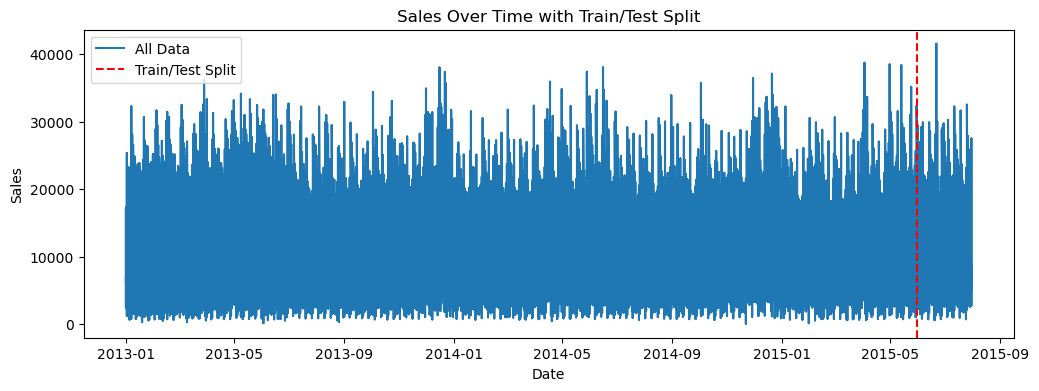

In [313]:
plt.figure(figsize=(12, 4))
plt.plot(train['Date'], train['Sales'], label='All Data')
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title("Sales Over Time with Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [314]:
# only use data of Sales > 0 and Open is 1
hold_test = hold_test[hold_test["Open"] != 0]
hold_test = hold_test[hold_test["Sales"] > 0]

hold_train = hold_train[hold_train["Open"] != 0]
hold_train = hold_train[hold_train["Sales"] > 0]

In [315]:
hold_test.shape

(58611, 18)

In [316]:
hold_train.shape

(785727, 18)

<Axes: xlabel='Sales', ylabel='Count'>

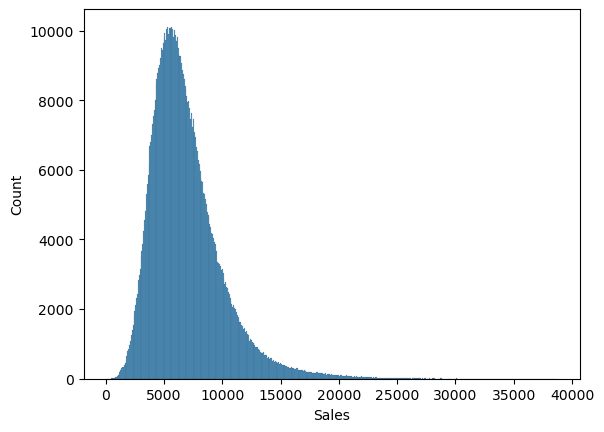

In [317]:
sns.histplot(data = hold_train, x='Sales')

<Axes: xlabel='Open', ylabel='Count'>

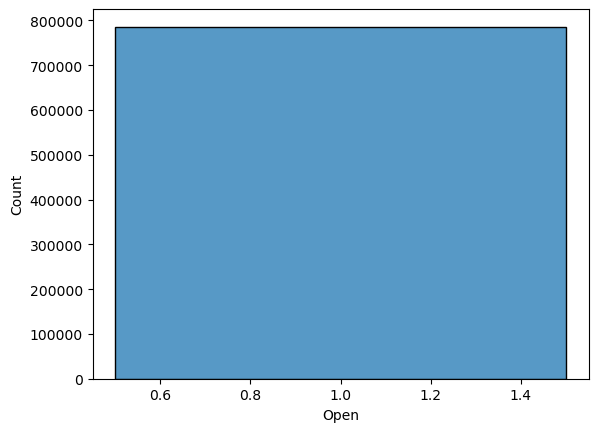

In [318]:

sns.histplot(data = hold_train, x='Open')

In [319]:
def features_create(data):
    # Map categorical values
    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
    for col in ['StoreType', 'Assortment', 'StateHoliday']:
        data[col].replace(mappings, inplace=True)

    # Extract date features
    data['Date'] = pd.to_datetime(data['Date'])

    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.isocalendar().week

    # Competition and promo durations
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear.fillna(data.Year)) + \
                               (data.Month - data.CompetitionOpenSinceMonth.fillna(data.Month))
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear.fillna(data.Year)) + \
                        (data.WeekOfYear - data.Promo2SinceWeek.fillna(data.WeekOfYear)) / 4.0
    data['CompetitionOpen'] = data['CompetitionOpen'].clip(lower=0)
    data['PromoOpen'] = data['PromoOpen'].clip(lower=0)

    # Promo month check
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0

    for interval in data.PromoInterval.unique():
        if interval:
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data


In [320]:
features_create(hold_train)
features_create(hold_test)
features_create(test)

print('Features creation finished')

Features creation finished


In [321]:
# drop the features of not help
hold_train.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
hold_test.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)

<Axes: >

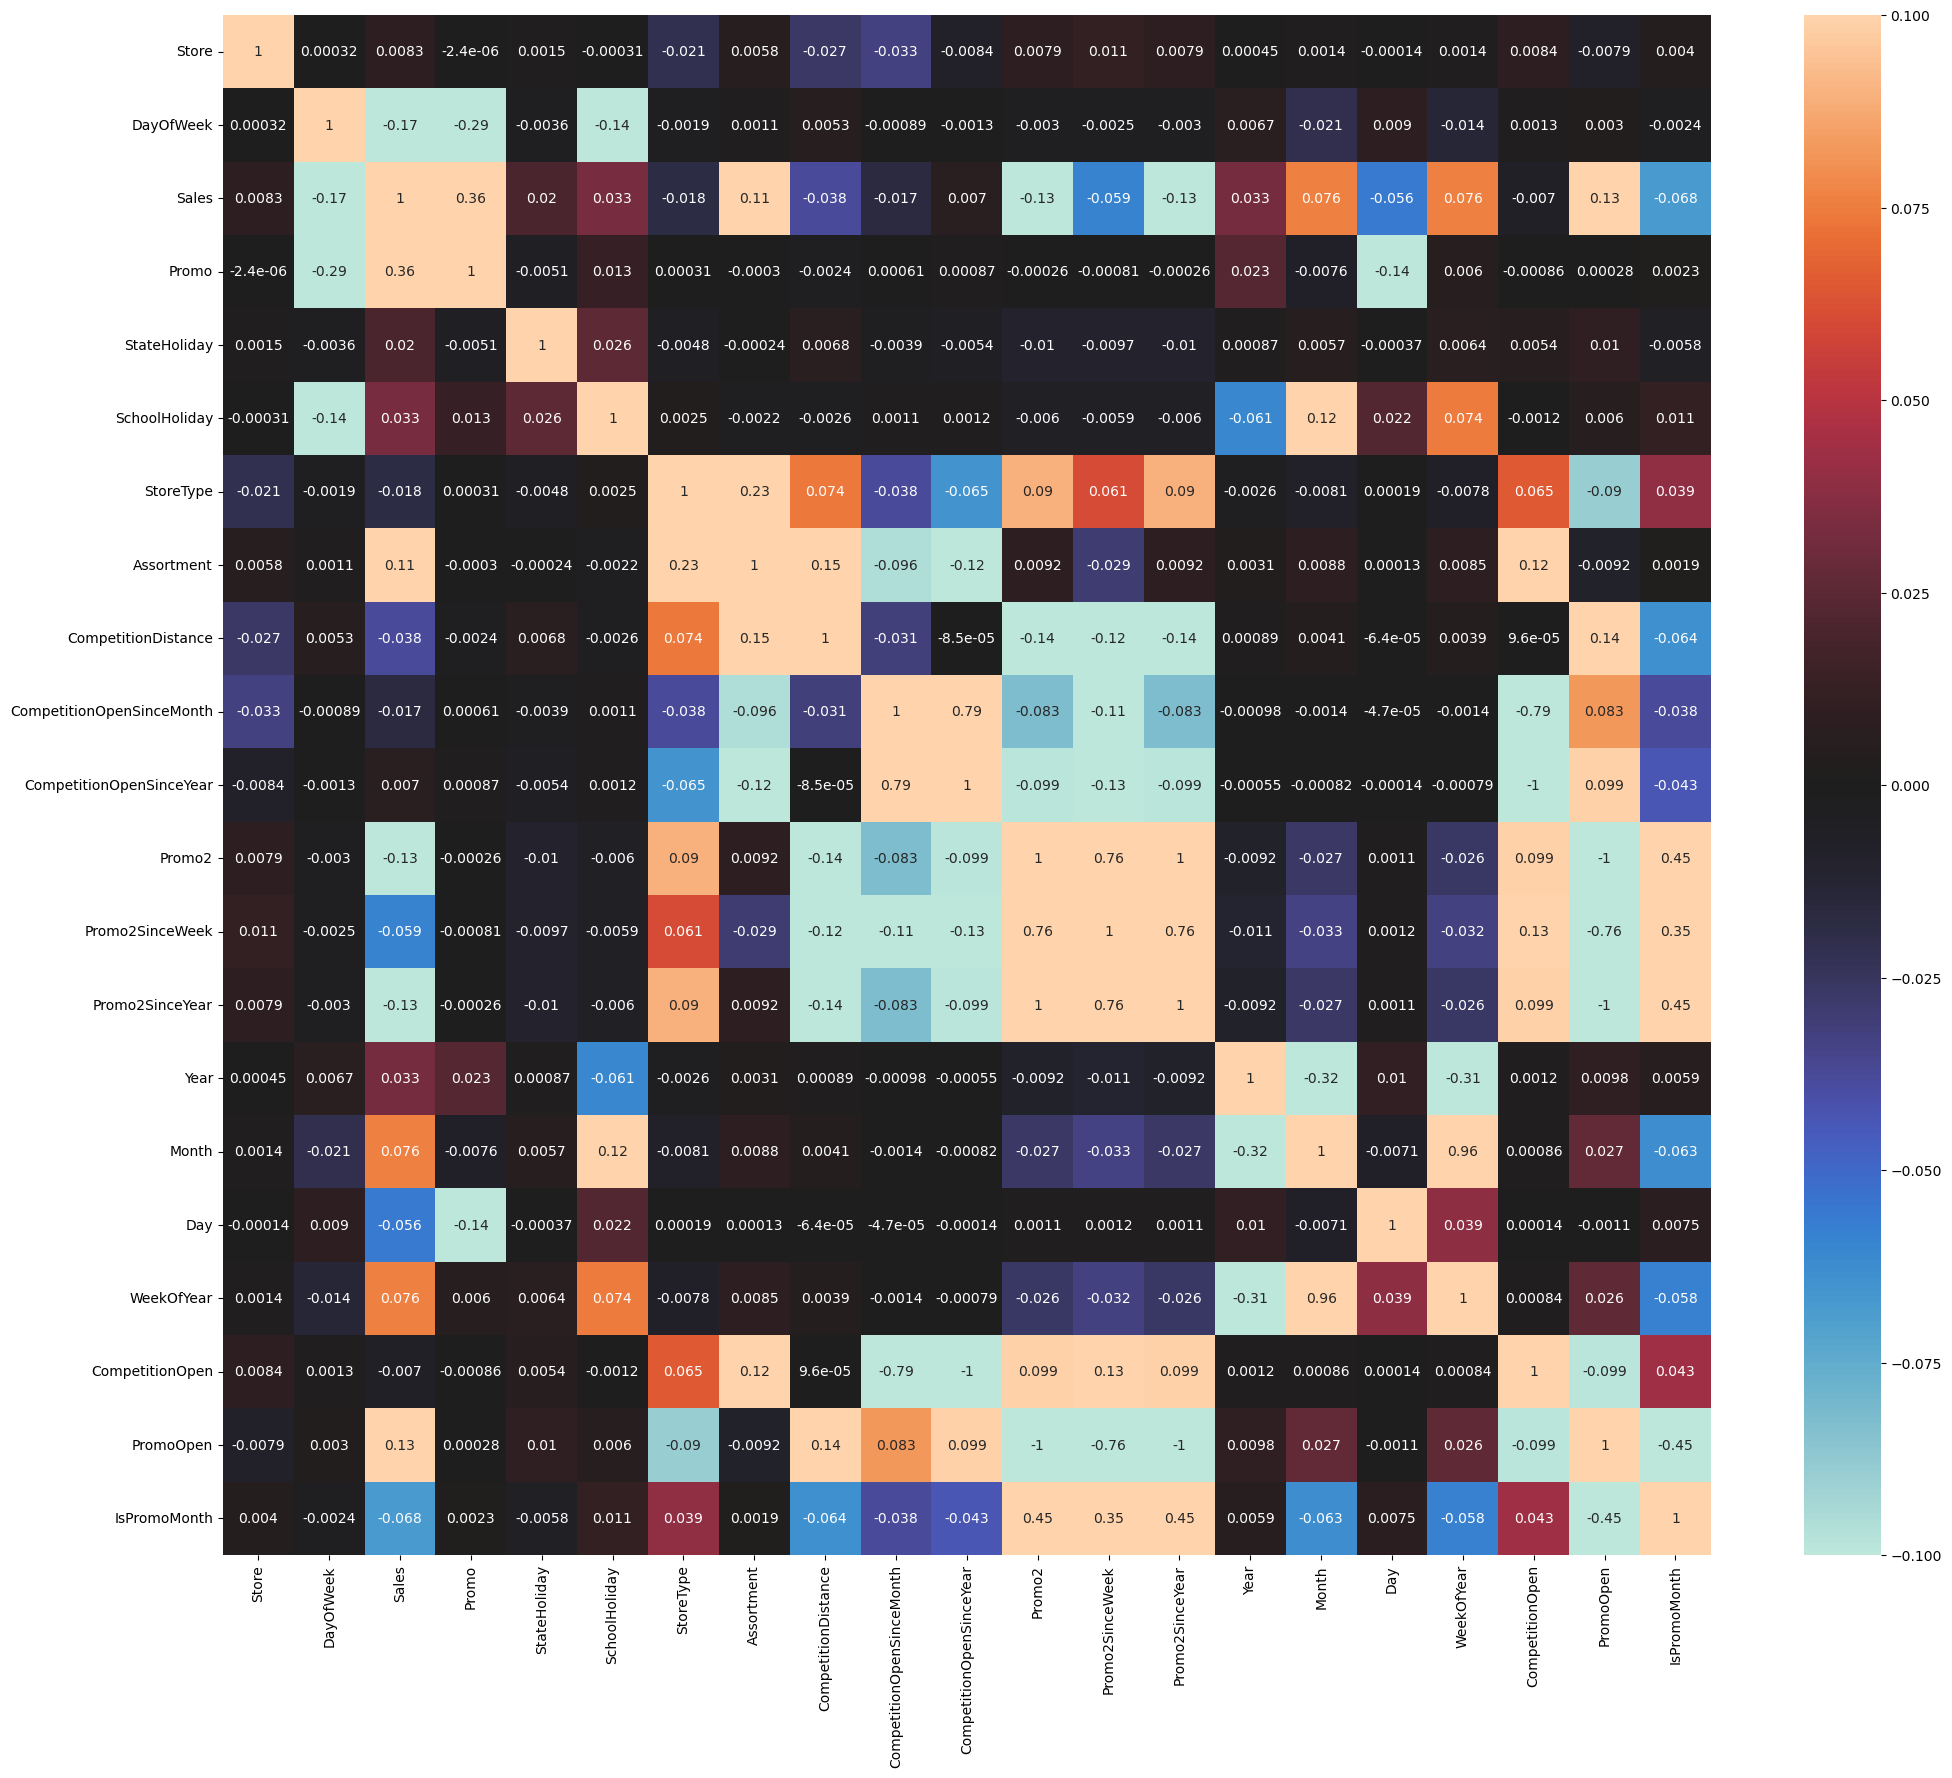

In [322]:
# the heat map of feature-feature and feature-label correlation 
plt.subplots(figsize=(24,20))
sns.heatmap(hold_train.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

In [323]:
hold_x_train = hold_train.drop(['Sales'],axis=1 )
hold_y_train = np.log1p(hold_train.Sales)

hold_x_test = hold_test.drop(['Sales'],axis=1 )
hold_y_test = np.log1p(hold_test.Sales)

In [324]:
x_test = test.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

In [326]:

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [327]:
params = {"objective": "reg:squarederror",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "verbosity": 1,
          "seed": 10
          }
num_boost_round = 6000


dtrain = xgb.DMatrix(hold_x_train, hold_y_train)
dvalid = xgb.DMatrix(hold_x_test, hold_y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]


In [328]:
print("Train a XGBoost model")

gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


print("validating")
hold_x_test.sort_index(inplace=True) 
hold_y_test.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(hold_x_test))
error = rmspe(np.expm1(hold_y_test), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[0]	train-rmse:0.42232	train-rmspe:0.55673	eval-rmse:0.41330	eval-rmspe:0.48820
[1]	train-rmse:0.41728	train-rmspe:0.54739	eval-rmse:0.40839	eval-rmspe:0.47939
[2]	train-rmse:0.41190	train-rmspe:0.53750	eval-rmse:0.40321	eval-rmspe:0.47006
[3]	train-rmse:0.40634	train-rmspe:0.52862	eval-rmse:0.39760	eval-rmspe:0.46198
[4]	train-rmse:0.40115	train-rmspe:0.51900	eval-rmse:0.39256	eval-rmspe:0.45365
[5]	train-rmse:0.39748	train-rmspe:0.51135	eval-rmse:0.38922	eval-rmspe:0.44673
[6]	train-rmse:0.39417	train-rmspe:0.50534	eval-rmse:0.38609	eval-rmspe:0.44165
[7]	train-rmse:0.39094	train-rmspe:0.50053	eval-rmse:0.38295	eval-rmspe:0.43805
[8]	train-rmse:0.38664	train-rmspe:0.49400	eval-rmse:0.37879	eval-rmspe:0.43175
[9]	train-rmse:0.38267	train-rmspe:0.48754	eval-rmse:0.37484	eval-rmspe:0.42565
[10]	train-rmse:0.37793	train-rmspe:0.47993	eval-rmse:0.37024	eval-rmspe:0.41872
[11]	train-rmse:0.37364	train-rmspe:0.47293	eval-rmse:0.36581	eval-rmspe:0.41208
[12]	train-rmse:

In [329]:
# analysis by hold set
res = pd.DataFrame(data = hold_y_test)
res['Prediction'] = yhat
res = pd.merge(hold_x_test, res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction / res.Sales
res['Error'] = abs(res.Ratio-1)
res['Weight'] = res.Sales / res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,...,31,31,82.0,24187.75,0,8.568646,8.558874,0.998860,0.001140,1.001142
1,742,4,1,0,1,4,3,4380.0,0.0,0.0,...,31,31,24187.0,24187.75,0,9.255409,9.158181,0.989495,0.010505,1.010617
2,748,4,1,0,1,4,1,2380.0,3.0,2010.0,...,31,31,64.0,52.25,1,8.920255,8.937812,1.001968,0.001968,0.998036
3,747,4,1,0,1,3,3,45740.0,8.0,2008.0,...,31,31,83.0,24187.75,0,9.278840,9.257870,0.997740,0.002260,1.002265
4,746,4,1,0,1,4,3,4330.0,2.0,2011.0,...,31,31,53.0,47.0,0,9.114160,9.027593,0.990502,0.009498,1.009589


Mean Ratio of predition and real sales data is 1.0045637618650622: store all
Mean Ratio of predition and real sales data is 1.0051177639336504: store 846
Mean Ratio of predition and real sales data is 1.0049094523611712: store 693
Mean Ratio of predition and real sales data is 1.0019337287831702: store 322


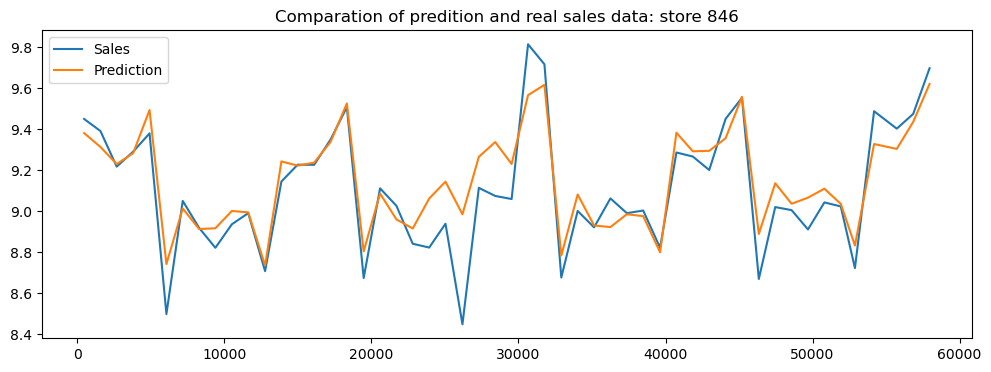

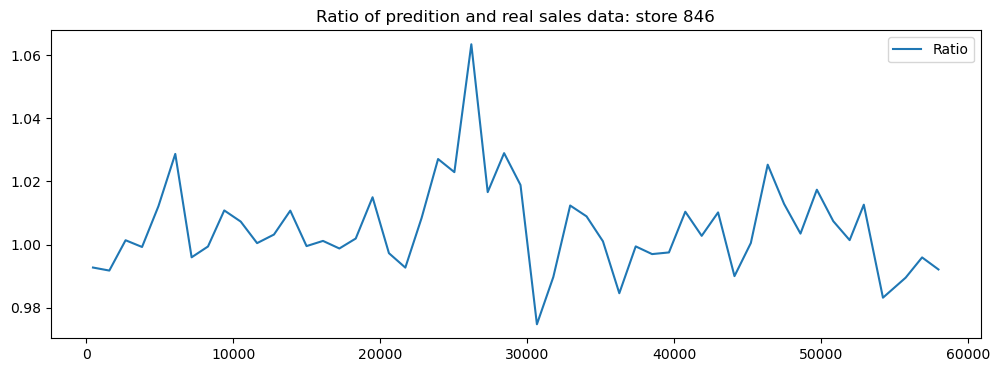

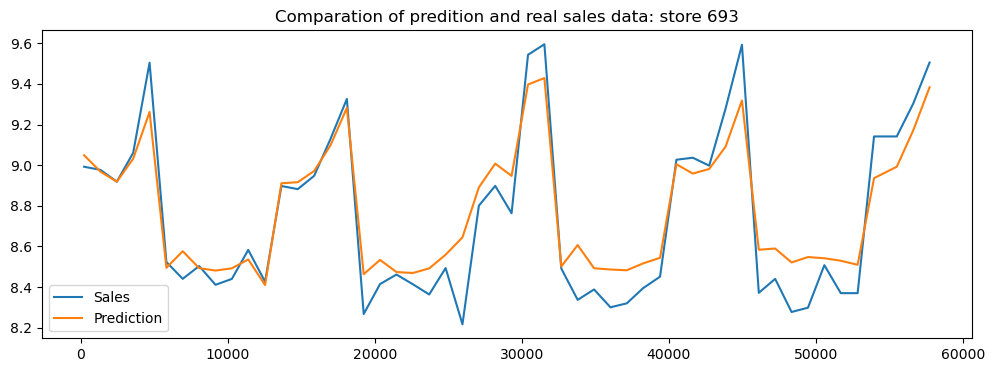

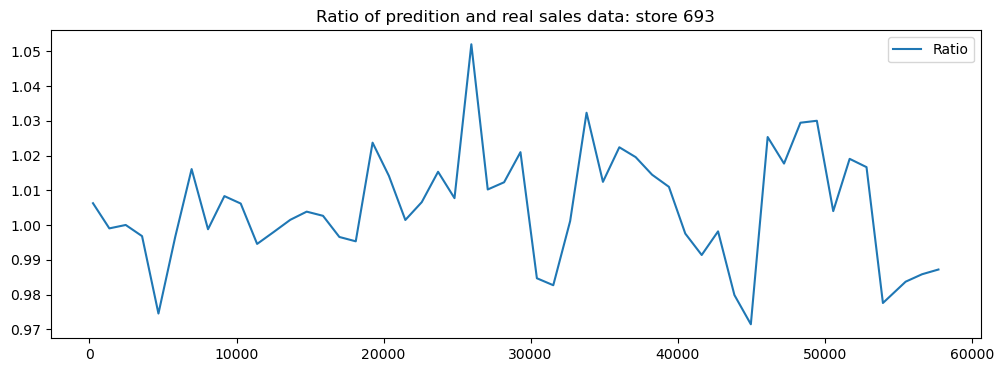

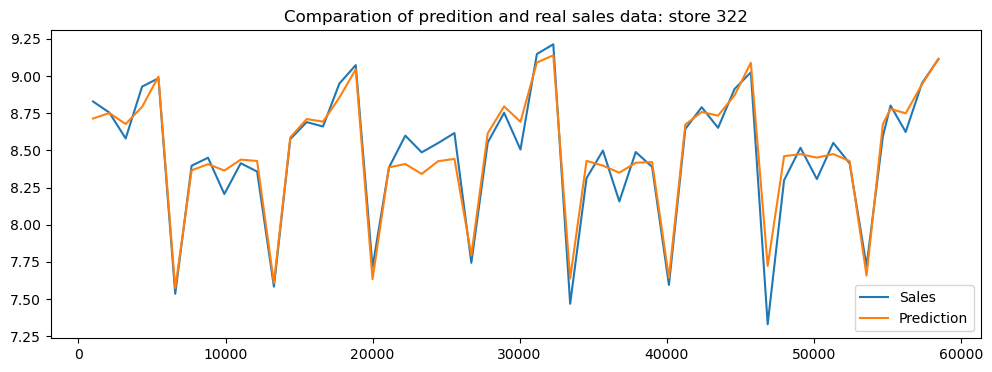

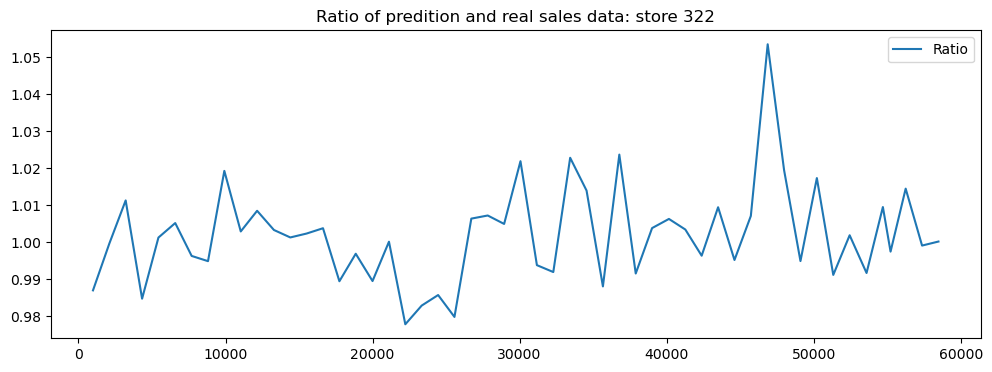

In [331]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
L=np.random.randint(low=1, high = 1115, size = 3) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res.Ratio.mean()))
for i in L:
    
    s1 = pd.DataFrame(res[res['Store']==i], columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i], columns = col_2)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of predition and real sales data: store {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}: store {}'.format(s2.Ratio.mean(),i))


In [332]:
# the worst 10 samples
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
21145,292,4,0,0,0,1,1,1100.0,6.0,2009.0,...,10,28,73.0,24187.0,0,6.920672,8.596529,1.242152,0.242152,0.805054
55247,415,3,1,1,0,4,3,6910.0,4.0,2005.0,...,4,23,122.0,24185.75,0,7.289611,8.839360,1.212597,0.212597,0.824676
33672,782,4,0,0,0,3,3,5390.0,8.0,2003.0,...,26,26,142.0,42.25,0,7.260523,8.629996,1.188619,0.188619,0.841312
56345,415,2,1,0,0,4,3,6910.0,4.0,2005.0,...,3,23,122.0,24185.75,0,7.713785,8.994984,1.166092,0.166092,0.857565
29561,909,2,1,0,0,1,3,1680.0,0.0,0.0,...,1,27,24187.0,67.5,0,8.174139,9.515299,1.164073,0.164073,0.859052
54800,415,4,1,0,0,4,3,6910.0,4.0,2005.0,...,5,23,122.0,24185.75,0,7.794823,8.954932,1.148831,0.148831,0.870450
38520,909,0,0,0,0,1,3,1680.0,0.0,0.0,...,22,26,24186.0,67.25,0,10.634701,9.168556,0.862136,0.137864,1.159910
53684,415,5,0,0,0,4,3,6910.0,4.0,2005.0,...,6,23,122.0,24185.75,0,7.779049,8.829266,1.135006,0.135006,0.881053
26746,292,5,0,0,0,1,1,1100.0,6.0,2009.0,...,4,27,73.0,24186.75,0,7.406711,8.359183,1.128596,0.128596,0.886057
26164,876,5,0,0,0,1,1,21790.0,4.0,2005.0,...,4,27,123.0,2.25,0,9.596215,8.369589,0.872176,0.127824,1.146557


weight correction
RMSPE for 0.990:0.130480
RMSPE for 0.991:0.128954
RMSPE for 0.992:0.127974
RMSPE for 0.993:0.127571
RMSPE for 0.994:0.127763
RMSPE for 0.995:0.128566
RMSPE for 0.996:0.129983
RMSPE for 0.997:0.132011
RMSPE for 0.998:0.134639
RMSPE for 0.999:0.137848
RMSPE for 1.000:0.141614
RMSPE for 1.001:0.145912
RMSPE for 1.002:0.150709
RMSPE for 1.003:0.155977
RMSPE for 1.004:0.161684
RMSPE for 1.005:0.167800
RMSPE for 1.006:0.174298
RMSPE for 1.007:0.181150
RMSPE for 1.008:0.188332
RMSPE for 1.009:0.195820
Best weight for Score:0.993    0.127571
dtype: float64


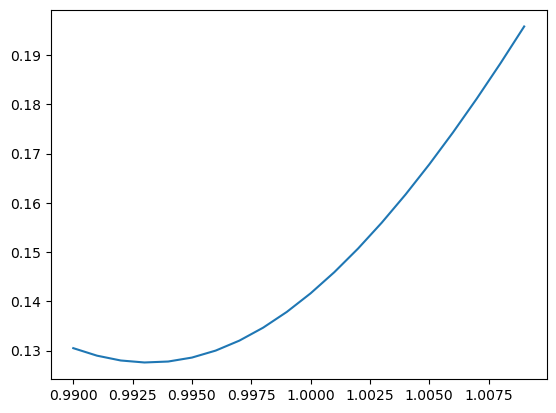

In [333]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(hold_y_test), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [ ]:
# correction by store
L = range(1115)
W_ho = []
W_test = []
for i in L:
    s1 = pd.DataFrame(res[res['Store'] == i+1], columns = col_1)
    s2 = pd.DataFrame(x_test[x_test['Store'] == i+1])
    W1=[ (0.990 + (i /1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction * w))
        S.append(error)
    Score = pd.Series(S, index = W1)
    BS = Score[Score.values == Score.values.min()]
    a = np.array(BS.index.values)
    b_ho = a.repeat(len(s1))
    b_test = a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [335]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(hold_y_test), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.131425


In [ ]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(x_test)
test_predections = gbm.predict(dtest)

result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_predections)})
result.to_csv("Rossmann_submission_1.csv", index=False)

result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_predections * 0.995)})
result.to_csv("Rossmann_submission_2.csv", index=False)

result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_predections * W_test)})
result.to_csv("Rossmann_submission_3.csv", index=False)


Make predictions on the test set


In [ ]:
hold_y_test

(58611,)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

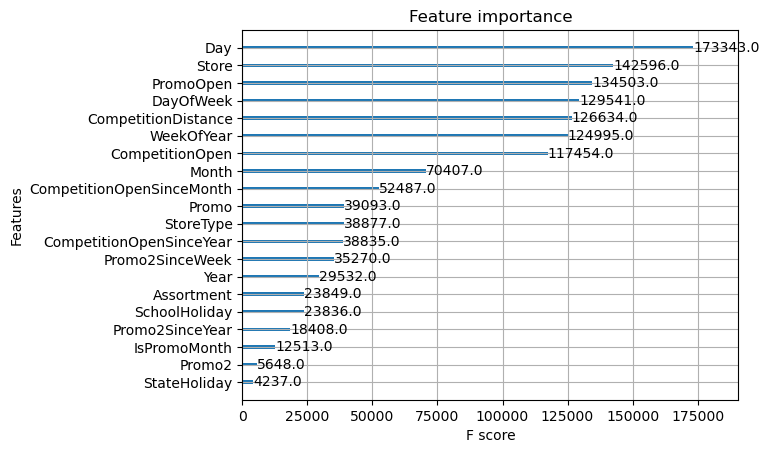

In [336]:
# feature importance
xgb.plot_importance(gbm)